<a href="https://colab.research.google.com/github/sagar9926/MTech_Atificial_Intelligence/blob/main/ML1/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes Classifier :

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features. 

\begin{equation*}
P(y\mid x_{i}) =  \frac{P(y) * \prod_{i=1}^{i = n} P(x_{i}\mid y)}{P(x)}
\end{equation*}


__Liklihood probability__ for continuous features can be calculated as follows : 

\begin{equation*}
P(x_{i}\mid y) = \frac{1}{\sqrt{2\pi \sigma_y^{2}}} \exp \left(-\frac{(x_{i} -\mu_{y})^2}{2\sigma_y^{2}} \right)
\end{equation*}

Here 

* Posterioir Probability is given by :
\begin{equation*} P(y\mid x_{i}) \end{equation*} 


* Liklihood Probability is given by :
\begin{equation*} P(x_{i}\mid y) \end{equation*} 

* Evidence or Normalisation constant is given by :
\begin{equation*} P(x)\end{equation*} 

* Prior Probability is given by :
\begin{equation*} P(y)\end{equation*} 

# Question 1 

## Dataset : Iris Dataset

Use sklearn library for loading iris dataset.

__Aim__: Classification using Naive Bayes classifier

```
● Apply Naive bayes classifier assuming all features are independent.
Do not use any predefined library for classification
Report overall accuracy, class wise accuracy, confusion matrix and ROC curve.
```

In [1]:
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_curve, auc

### Loading Dataset

In [2]:
# Importing dataset
iris = datasets.load_iris()
df_iris = pd.DataFrame(iris.data,columns = iris.feature_names)
df_iris['target'] = iris.target

### Perform Train - Test split 

In [3]:
X, y = df_iris.iloc[:, :-1], df_iris.iloc[:, -1]

# # split on train and test 0.7/0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(105, 4) (105,)
(45, 4) (45,)


## Plotting Distributions

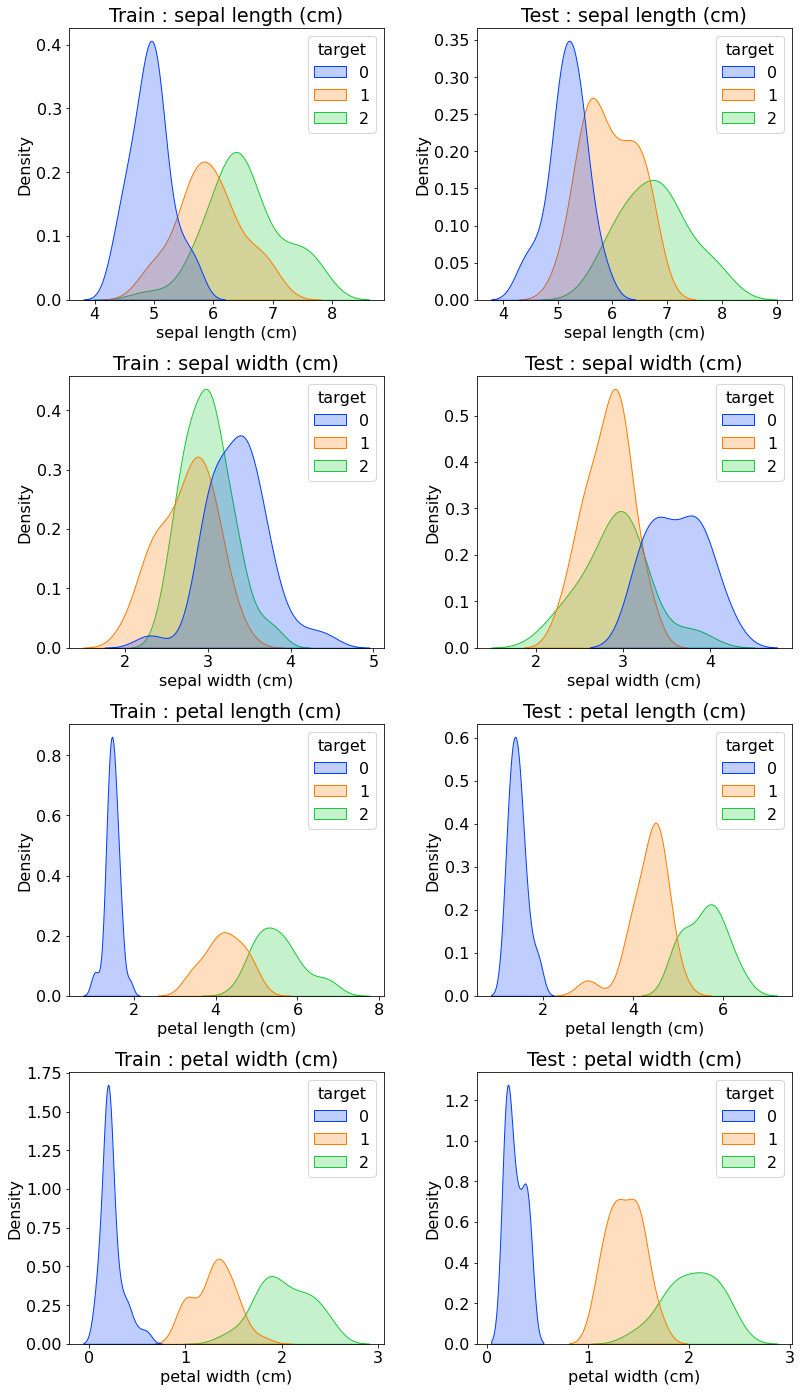

In [4]:
df_train_plot = X_train.copy()
df_train_plot['target'] = y_train
matplotlib.rcParams.update({'font.size': 16})
df_test_plot = X_test.copy()
df_test_plot['target'] = y_test
names = df_train_plot.columns[:-1]
fig, axes = plt.subplots(4,2)
fig.set_size_inches(12, 20)
fig.tight_layout(pad=3.0)

# for i,t in enumerate(names):
j = 0
col_count = 0
for i in range(4):
  sns.kdeplot(data=df_train_plot, x= names[col_count], hue="target",shade = True,palette ='bright' , ax=axes[i,j])
  axes[i,j].set_title(f'Train : {names[col_count]}')
  sns.kdeplot(data=df_test_plot, x= names[col_count], hue="target",shade = True,palette ='bright' , ax=axes[i,j+1])
  axes[i,j + 1].set_title(f'Test : {names[col_count]}')
  col_count += 1


### Creating a Naive Bayes class

In [5]:
class NaiveBayesClassifier:

  """
  Training Naive Bayes Classifier from scratch.
  
  ####################################################################################################
  Assumption :
  * Continuous features are assumed to follow Gaussian distribution with mean mu and variance sigma^2
  ##################################################################################################

  P(y|X) = (P(X|y)*P(y))/P(X)

  where :
  X : Input Features
  y : Traget Variable
  P(y|X) = Posterior Probability
  P(X|y) = Liklihood
  P(y) = Prior
  P(X) = Evidence

  """

  def __init__(self,prior = None):

    self.liklihood = {}
    self.posteriors = []
    self.prediction = []
    self.probability = []
    self.mean = None
    self.variance = None 
    if prior :
      self.prior = prior
    else :
      self.prior = {} 
 
  def calculate_prior(self ,target ,classes):
    """
    Returns the prior probabilites for all classes.

    Parameters:
        target : target class labels for all input feature vectors.
        classes :  Names corresponding to targets

    Returns:
        prior : Dictionary with target class as key and corresponding prior probability as value
    """
    prior = {}
    for index in classes:
      prior[index] = (target == index).sum()/len(target) 
    return prior


  def feature_statistics(self , features , target):
    """
    Returns feature statistics such ,mean and variance for all features corresponding to each class.

    Parameters:
        target : target class labels for all input feature vectors.
        features : Pandas dataframe in which every row corresponds to a feature vector

    Returns:
        mean : Pandas dataframe with mean of all features corresponding to each class. 
        variance : Pandas dataframe with variance of all features corresponding to each class.
    """

    var = lambda x : np.var(x)  
    mean = features.groupby(target).mean().reset_index()
    variance = features.groupby(target).var(ddof = 0).reset_index()
    return mean , variance


  def gaussian_probability(self,test_feature,classes, mean, variance):
    
    """
    Returns liklihood probability for all features corresponding to each class in a feature vector.

    Parameters:
        test_feature : Pandas dataframe in which every row corresponds to a feature vector from test dataset.
        classes :  Names corresponding to targets
        mean : Pandas dataframe with mean of all features corresponding to each class. 
        variance : Pandas dataframe with variance of all features corresponding to each class.

    Returns:
        liklihood_prob : A dictionary liklihood probability for all features corresponding to each class in a feature vector
    """

    liklihood_prob = {}
    for index in classes:
      mean_vector = np.array(mean[mean['target'] == index])[0][1:]
      variance_vector = np.array(variance[variance['target'] == index])[0][1:]
      mean_diff_square = (np.array(test_feature) - mean_vector)**2
      liklihood_prob[index] = (1/np.sqrt(2*np.pi*variance_vector)*np.exp(-1*0.5*mean_diff_square/variance_vector))
    return liklihood_prob


  def calculate_posterior(self,test_feature,classes):

    """
    Returns posterior probability for all features corresponding to each class in a feature vector.

    Parameters:
        test_feature : Pandas dataframe in which every row corresponds to a feature vector from test dataset.
        classes :  Names corresponding to targets
        
    Returns:
        liklihood_prob : posterior probability for all features corresponding to each class in a feature vector
    """

    posteriors = {}
    self.liklihood = self.gaussian_probability(test_feature ,classes ,self.mean,self.variance)
    for index in classes :
      posteriors[index] = reduce(lambda x , y : x*y , self.liklihood[index]) * self.prior[index]
    return posteriors


  def fit(self, features, target):

    """
    Fit model on training data by calculating model parameters and liklihood from train dataset.

    Parameters:
        target : target class labels for all input feature vectors.
        features : Pandas dataframe in which every row corresponds to a feature vector
        
   """
    
    self.classes = target.unique()
    if self.prior :
      pass
    else:
      self.prior = self.calculate_prior(target , self.classes)
    self.mean , self.variance = self.feature_statistics(features , target)
    

  def predict(self,test_features):
    """
    Returns predictions using the features learnt from train dataset.

    Parameters:
        test_feature : Pandas dataframe in which every row corresponds to a feature vector from test dataset.

    """

    for i in range(len(test_features)):
      self.posteriors.append(self.calculate_posterior(test_features.iloc[i].values,self.classes))
      self.prediction.append(sorted(self.posteriors[i].items(),key = lambda x : x[1],reverse = True)[0][0])
    return self.posteriors


  def accuracy(self , target,names):

    """
    Calculate the overall and class wise accuracy of the model

    """

    overall_accuracy = sum(target == self.prediction) / len(target)
    print(f"Overall accuracy of data : {round(overall_accuracy*100,2)}%")

    data = pd.DataFrame({'Actual Class' : target.values,'Predicted Class':self.prediction})
    for class_ in target.unique():
      temp = data[data['Actual Class'] == class_]
      print(f"{names[class_]} accuracy of data : {round(sum(temp['Actual Class'] == temp['Predicted Class']) / len(temp)*100,2)}%")

  def confusion_matrix(self,target):
    
    """
    Estimate the Confusion matrix

    """

    df_temp = pd.DataFrame({'Actual Class' : target,'Predicted Class' : self.prediction})
    Confusion_matrix = df_temp.groupby(['Predicted Class','Actual Class']).agg({'Predicted Class':'count'})
    Confusion_matrix.columns = ['Instance_count']
    Confusion_matrix['Instance_count'] = Confusion_matrix['Instance_count'].astype(int)
    Confusion_matrix.reset_index(inplace = True)
    Confusion_matrix = Confusion_matrix.pivot(index='Actual Class', columns='Predicted Class', values='Instance_count').fillna(0)
    return Confusion_matrix


  def probability_score(self,posteriror_unnormalise):
     probability = []
     for i in range(len(posteriror_unnormalise)):
       prob_score = {key : posteriror_unnormalise[i][key]/sum(posteriror_unnormalise[i].values()) for key in posteriror_unnormalise[i].keys()}
       probability.append(prob_score)
       self.probability = probability
     return self.probability


### Model Training

In [6]:
model = NaiveBayesClassifier()
model.fit(X_train, y_train)

### Making predictions using trained model

In [7]:
posteriors = model.predict(X_test) 
model.accuracy(y_test,iris.target_names)

Overall accuracy of data : 93.33%
setosa accuracy of data : 100.0%
versicolor accuracy of data : 88.89%
virginica accuracy of data : 92.31%


### Plotting Confusion Matrix (Test Set)

In [8]:
model.confusion_matrix(y_test)

Predicted Class,0,1,2
Actual Class,,,
0,14.0,0.0,0.0
1,0.0,16.0,2.0
2,0.0,1.0,12.0


### Plotting ROC Curve

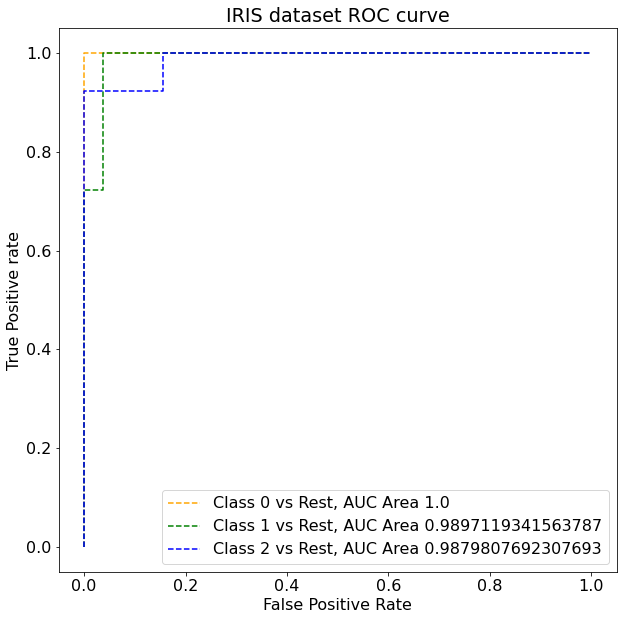

In [9]:
roc_input = model.probability_score(posteriors)
pred_prob = np.array(list(zip([d[0] for d in roc_input] ,[d[1] for d in roc_input], [d[2] for d in roc_input])))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = {}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting
fig, axes = plt.subplots(1,1)
fig.set_size_inches(10, 10)
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=f'Class 0 vs Rest, AUC Area {roc_auc[0]}')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=f'Class 1 vs Rest, AUC Area {roc_auc[1]}')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=f'Class 2 vs Rest, AUC Area {roc_auc[2]}')
plt.title('IRIS dataset ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

### Plotting Confusion matrix (Train Set)

In [10]:
model = NaiveBayesClassifier()
model.fit(X_train, y_train)
posteriors = model.predict(X_train) 
model.confusion_matrix(y_train)

Predicted Class,0,1,2
Actual Class,,,
0,36.0,0.0,0.0
1,0.0,29.0,3.0
2,0.0,2.0,35.0


# Question 2 :

__Dataset__: Wine dataset (use sklearn library for loading the dataset)

__Aim__: Naive Bayes Classification
```
Shuffle the data with seed value 42 and perform a 70- 30 stratified split of the data into a train and test set.
Also, plot the class-wise distribution of data in the train and test set (one for train set and one for test set).

Compare the distributions. Now, perform classification as follows:

* Train a Gaussian Naive Bayes classifier and report (a) the class priors, (b) mean and variance of
each feature per class.

* Train another Gaussian Naive Bayes classifier by setting prior probability for the classes. Repeat this
experiment by setting priors in the ratios: (a) 40-40-20 and (b) 80-10-10.
```

In [11]:
wine = datasets.load_wine()
df_wine = pd.DataFrame(wine.data,columns = wine.feature_names)
df_wine['target'] = wine.target

In [12]:
X, y = df_wine.iloc[:, :-1], df_wine.iloc[:, -1]

# # split on train and test 0.7/0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(124, 13) (124,)
(54, 13) (54,)


In [13]:
df_wine.target.unique()

array([0, 1, 2])

In [14]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### Plotting Distributions

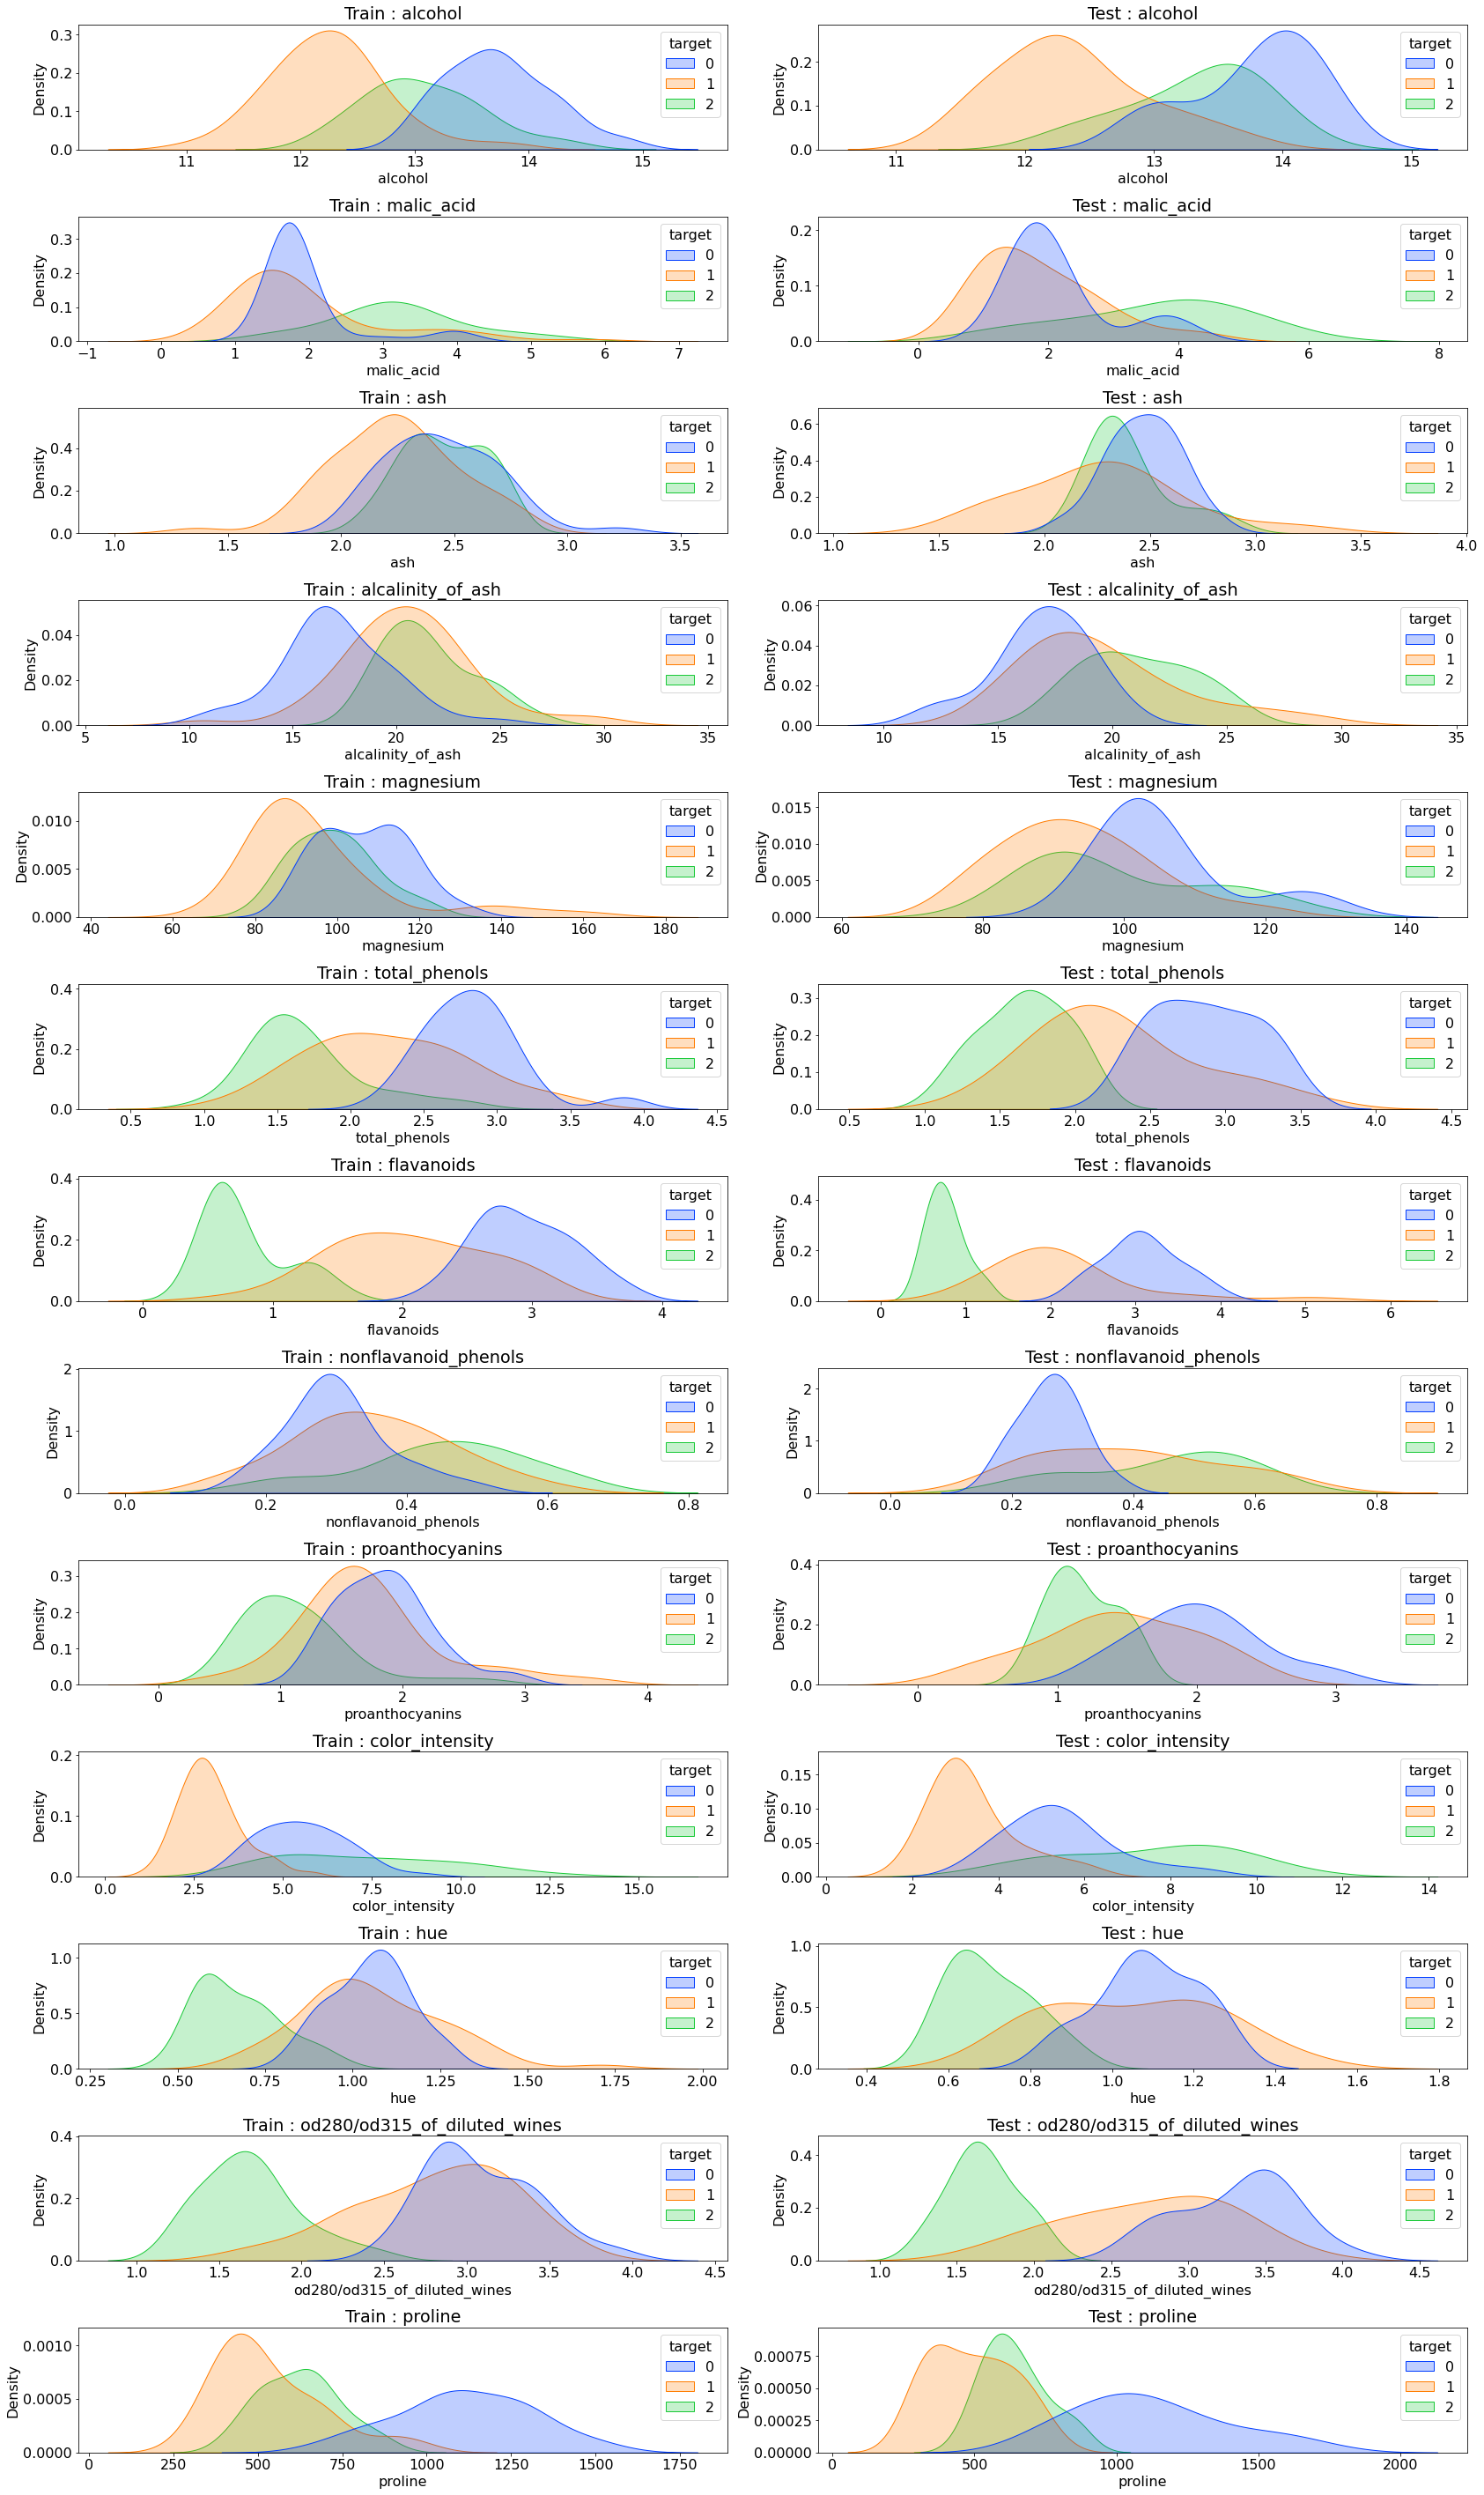

In [15]:
df_train_plot = X_train.copy()
df_train_plot['target'] = y_train
matplotlib.rcParams.update({'font.size': 16})
df_test_plot = X_test.copy()
df_test_plot['target'] = y_test
names = df_train_plot.columns[:-1]
fig, axes = plt.subplots(13,2)
fig.set_size_inches(24, 40)
fig.tight_layout(pad=3.0)

# for i,t in enumerate(names):
j = 0
col_count = 0
for i in range(13):
  sns.kdeplot(data=df_train_plot, x= names[col_count], hue="target",shade = True,palette ='bright' , ax=axes[i,j])
  axes[i,j].set_title(f'Train : {names[col_count]}')
  sns.kdeplot(data=df_test_plot, x= names[col_count], hue="target",shade = True,palette ='bright' , ax=axes[i,j+1])
  axes[i,j + 1].set_title(f'Test : {names[col_count]}')
  col_count += 1


### Model Training

In [16]:
model = NaiveBayesClassifier()
model.fit(X_train, y_train)

### Making predictions using trained model

In [17]:
predictions = model.predict(X_test) 

In [18]:
model.accuracy(y_test,wine.target_names)

Overall accuracy of data : 100.0%
class_0 accuracy of data : 100.0%
class_1 accuracy of data : 100.0%
class_2 accuracy of data : 100.0%


In [19]:
model.prior

{0: 0.33064516129032256, 1: 0.4032258064516129, 2: 0.2661290322580645}

In [20]:
model.confusion_matrix(y_test)

Predicted Class,0,1,2
Actual Class,,,
0,18.0,0.0,0.0
1,0.0,21.0,0.0
2,0.0,0.0,15.0


#### Adjusting prior to 40-40-20

In [21]:
prior = {0: 0.40, 1: 0.40, 2: 0.20}
model = NaiveBayesClassifier(prior)
model.fit(X_train, y_train)
model.predict(X_test) 
model.accuracy(y_test,wine.target_names)

Overall accuracy of data : 98.15%
class_0 accuracy of data : 100.0%
class_1 accuracy of data : 95.24%
class_2 accuracy of data : 100.0%


In [22]:
model.confusion_matrix(y_test)

Predicted Class,0,1,2
Actual Class,,,
0,18.0,0.0,0.0
1,1.0,20.0,0.0
2,0.0,0.0,15.0


#### Adjusting prior to 80-10-10

In [23]:
prior = {0: 0.80, 1: 0.10, 2: 0.10}
model = NaiveBayesClassifier(prior)
model.fit(X_train, y_train)
model.predict(X_test) 
model.accuracy(y_test,wine.target_names)

Overall accuracy of data : 98.15%
class_0 accuracy of data : 100.0%
class_1 accuracy of data : 95.24%
class_2 accuracy of data : 100.0%


In [24]:
model.confusion_matrix(y_test)

Predicted Class,0,1,2
Actual Class,,,
0,18.0,0.0,0.0
1,1.0,20.0,0.0
2,0.0,0.0,15.0


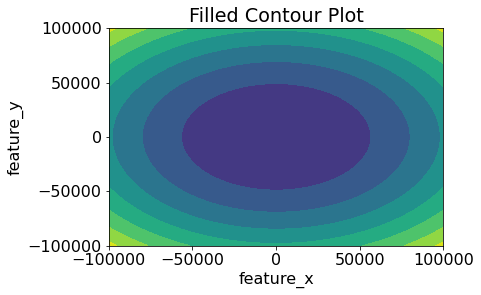

In [25]:
# Implementation of matplotlib function
import matplotlib.pyplot as plt
import numpy as np
  
feature_x = np.linspace(-100000.0, 100000.0, 7000)
feature_y = np.linspace(-100000.0, 100000.0, 7000)
  
# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)
  
fig, ax = plt.subplots(1, 1)
  
Z = ((X - 100) ** 2)/8 + ((Y-7) ** 2)/6 - 10
  
# plots filled contour plot
ax.contourf(X, Y, Z)
  
ax.set_title('Filled Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
  
plt.show()